# Sarcasm Detection in Article News Headlines Using Machine Learning

### In this project we would detect whether a headline is sarcastic or not. The dataset used is News Headlines Dataset downloaded from Kaggle. After EDA, NLTK (Natural Language Toolkit )  python library is used for  tokenization and preprocessing of the data. The machine learning model used for classification is Sequential Model of Deep Learning. Additionally, alternative techniques will be explored.

The implementation is as follows:

#### Importing Required Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from wordcloud import WordCloud
 
#for model building and evaluation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#for results analysis
from sklearn.metrics import classification_report, confusion_matrix

### Loading the two datasets into one dataframe

In [8]:
data1 = pd.read_json("Sarcasm_Headlines_Dataset.json", lines=True)
data2 = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
data = pd.concat([data1, data2], ignore_index=True)
 
# Display the concatenated data
print(data.head())

                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  


### Assessing the Data

In [9]:
# Information on the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55328 entries, 0 to 55327
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  55328 non-null  object
 1   headline      55328 non-null  object
 2   is_sarcastic  55328 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


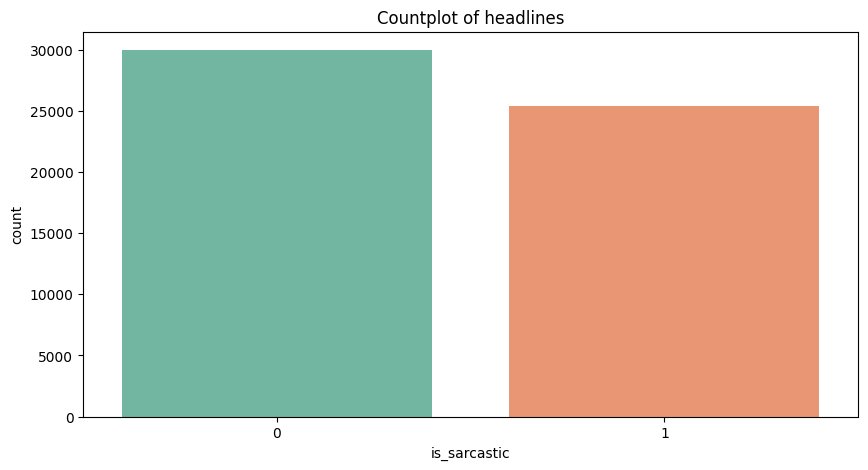

In [15]:
# Check if the data is well balanced 
 
# Check number of headlines by is_sarcastics (0 or 1)
plt.figure(figsize=(10, 5))
sns.countplot(x='is_sarcastic', data=data, palette="Set2").set_title(
    "Countplot of headlines")
plt.show()

### Data Preprocessing

In [18]:
#downloading the stopwords list from nltk for data cleaning
nltk.download('stopwords')
stopwords_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\uc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
def clean_text(sentences):
    # convert text to lowercase
    text = sentences.lower()
    # remove text in square brackets
    text = re.sub('\[.*?\]', '', text)
    # removing punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # removing words containing digits
    text = re.sub('\w*\d\w*', '', text)
    # Join the words
    text = ' '.join([word for word in text.split()
                     if word not in stopwords_list])
    return text
 
# Testing clean_text function on one of the headlines
print(data['headline'].iloc[1])
clean_text(data['headline'].iloc[1])

the 'roseanne' revival catches up to our thorny political mood, for better and worse


'roseanne revival catches thorny political mood better worse'

In [20]:
#new column to store cleaned text 
data['cleaned_headline']=data['headline'].map(clean_text)

In [44]:
# Combining all sarcastic cleaned headlines into a single text
Sarcastic_text = ' '.join(
    data['cleaned_headline'][data['is_sarcastic'] == 1].tolist())
  
# Combine all non-sarcastic cleaned headlines into a single text
Non_Sarcastic_text = ' '.join(
    data['cleaned_headline'][data['is_sarcastic'] == 0].tolist())


### Data Visualization

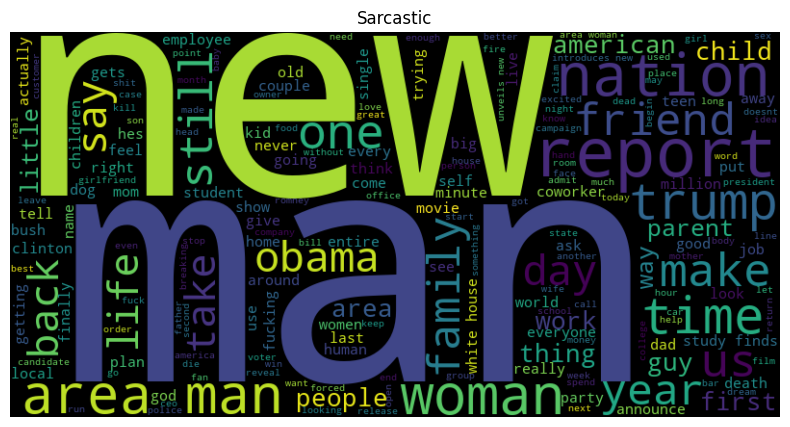

In [45]:
# Creating a WordCloud of Sarcastic words
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(Sarcastic_text)
 
# Display the WordCloud without axes
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Sarcastic')
plt.show()

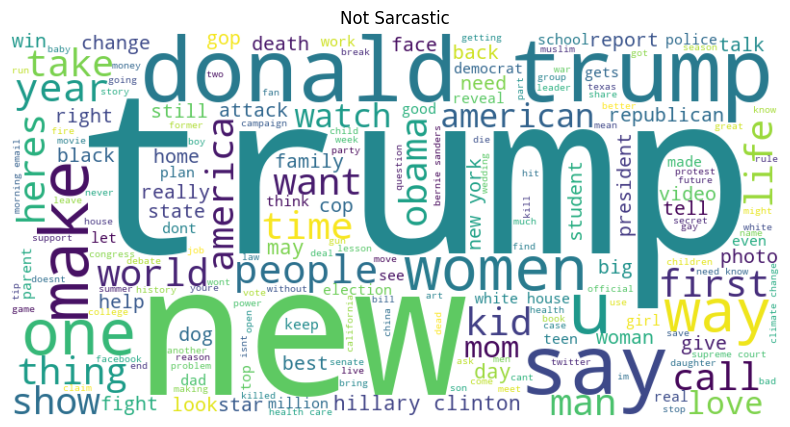

In [24]:
# Creating a WordCloud of Non-Sarcastic words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(Non_Sarcastic_text)
 
# Display the WordCloud without axes
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Not Sarcastic')
plt.show()

### Splitting the data for train and test datasets

In [25]:
#coverting the columns into lists
text = data['cleaned_headline'].tolist()
label = data['is_sarcastic'].tolist()

In [26]:
# train :test : validation = 80:10:10
train_portion = .8

# Training dataset
train_size = int(len(text) * train_portion)
train_text = text[:train_size]
train_label = label[:train_size]
# Validations dataset
valid_size = train_size+int((len(text)-train_size)/2)
val_text = text[train_size:valid_size]
val_label = label[train_size:valid_size]
# Testing dataset
test_text = text[valid_size:]
test_label = label[valid_size:]
 
# Check
print('Training data :', len(train_text), len(train_label))
print('Validations data :', len(val_text), len(val_label))
print('Testing data :', len(test_text), len(test_label))

Training data : 44262 44262
Validations data : 5533 5533
Testing data : 5533 5533


### Data Tokenization and Processing for the Model

In [27]:
# Setting the parameters for tokenization of words

vocab_size = 10000 # Max len of unique words
embedding_dim = 200 # Embedding dimension value
max_length = 60 # Max length of sentence
padding_type = 'post' # type of padding style
oov_tok = '<OOV>' # Unknown words

# Create a tokenizer with a specified vocabulary size and out-of-vocabulary token
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
# Fit the tokenizer on the training text data to create word-to-index mapping
tokenizer.fit_on_texts(train_text)

In [28]:
# Getting the word index from the tokenizer
word_index = tokenizer.word_index
 
word_index

{'<OOV>': 1,
 'new': 2,
 'man': 3,
 'trump': 4,
 'us': 5,
 'report': 6,
 'one': 7,
 'area': 8,
 'woman': 9,
 'donald': 10,
 'says': 11,
 'day': 12,
 'like': 13,
 'get': 14,
 'first': 15,
 'time': 16,
 'people': 17,
 'trumps': 18,
 'obama': 19,
 'house': 20,
 'life': 21,
 'still': 22,
 'make': 23,
 'white': 24,
 'women': 25,
 'back': 26,
 'clinton': 27,
 'world': 28,
 'could': 29,
 'years': 30,
 'family': 31,
 'americans': 32,
 'way': 33,
 'study': 34,
 'black': 35,
 'gop': 36,
 'bill': 37,
 'would': 38,
 'best': 39,
 'cant': 40,
 'really': 41,
 'police': 42,
 'american': 43,
 'watch': 44,
 'show': 45,
 'school': 46,
 'know': 47,
 'home': 48,
 'good': 49,
 'nation': 50,
 'going': 51,
 'finds': 52,
 'say': 53,
 'things': 54,
 'president': 55,
 'death': 56,
 'video': 57,
 'last': 58,
 'love': 59,
 'parents': 60,
 'year': 61,
 'mom': 62,
 'big': 63,
 'state': 64,
 'health': 65,
 'hillary': 66,
 'every': 67,
 'kids': 68,
 'need': 69,
 'getting': 70,
 'may': 71,
 'gets': 72,
 'campaign': 73,

In [29]:
# Converting training text to sequences of word indices
tokenizer.texts_to_sequences(train_text[:5])

[[204, 1, 740, 2953, 2235, 245, 35, 1958, 2515, 8487],
 [8488, 3234, 2422, 8489, 289, 3081, 151, 853],
 [62, 597, 719, 1063, 1840, 496, 4199, 116, 9676],
 [1320, 130, 337, 1439, 219, 3385, 1, 703],
 [4779, 5143, 679, 1, 454, 490, 1137, 33]]

In [30]:
train_indices = tokenizer.texts_to_sequences(train_text)
# Padded the sequences to a fixed length
train_padded = pad_sequences(train_indices,
                             padding=padding_type,
                             maxlen=max_length)

In [31]:
# Convert validation text to sequences of word indices
val_indices = tokenizer.texts_to_sequences(val_text)
# Padding validation sequences to a fixed length
validation_padded = pad_sequences(val_indices,
                                  padding=padding_type,
                                  maxlen=max_length)
 
# Convert test text to sequences of word indices
test_indices = tokenizer.texts_to_sequences(test_text)
# Pad sequences to a fixed length
test_padded = pad_sequences(test_indices,
                            padding=padding_type,
                            maxlen=max_length)



print('Training vector :', train_padded.shape)
print('Validations vector :', validation_padded.shape)
print('Testing vector :', test_padded.shape)

Training vector : (44262, 60)
Validations vector : (5533, 60)
Testing vector : (5533, 60)


In [32]:
# Decode the sample training vector
tokenizer.sequences_to_texts([train_padded[0].tolist()])

['former <OOV> store clerk sues secret black code minority shoppers <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']

In [33]:
# Prepare labels for model
training_labels_final = np.array(train_label)
validation_labels_final = np.array(val_label)
testing_labels_final = np.array(test_label)
  
# Check shapes
print('Training vector :', training_labels_final.shape)
print('Validations vector :', validation_labels_final.shape)
print('Testing vector :', testing_labels_final.shape)

Training vector : (44262,)
Validations vector : (5533,)
Testing vector : (5533,)


### Defining the Model

In [34]:
# Import the TensorFlow library
import tensorflow as tf
 
# Define a sequential neural network model
model = tf.keras.Sequential([
    # Embedding layer for creating word embeddings
    tf.keras.layers.Embedding(
        vocab_size, embedding_dim, input_length=max_length),
 
    # GlobalMaxPooling layer to extract relevant features
    tf.keras.layers.GlobalMaxPool1D(),
 
    # First Dense layer with 40 neurons and ReLU activation
    tf.keras.layers.Dense(40, activation='relu'),
 
    # Dropout layer to prevent overfitting
    tf.keras.layers.Dropout(0.5),
 
    # Second Dense layer with 20 neurons and ReLU activation
    tf.keras.layers.Dense(20, activation='relu'),
 
    # Dropout layer to prevent overfitting
    tf.keras.layers.Dropout(0.5),
 
    # Third Dense layer with 10 neurons and ReLU activation
    tf.keras.layers.Dense(10, activation='relu'),
 
    # Dropout layer to prevent overfitting
    tf.keras.layers.Dropout(0.2),
 
    # Final Dense layer with 1 neuron and sigmoid activation for binary classification
    tf.keras.layers.Dense(1, activation='sigmoid')
])
 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 200)           2000000   
                                                                 
 global_max_pooling1d (Globa  (None, 200)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 40)                8040      
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                820       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                        

Model Compiling

In [35]:
# Compile the model with specified loss function, optimizer, and evaluation metrics
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

Training the Model

In [36]:
# number of training epochs
num_epochs = 5
 
# Fit the model to the training data and validate on the validation data
history = model.fit(
    train_padded, training_labels_final,
    epochs=num_epochs,
    validation_data=(validation_padded, validation_labels_final)
)

Epoch 1/5
1384/1384 [==============================] - 66s 46ms/step - loss: 0.5067 - accuracy: 0.7401 - val_loss: 0.2996 - val_accuracy: 0.8784
Epoch 2/5
1384/1384 [==============================] - 63s 46ms/step - loss: 0.2355 - accuracy: 0.9179 - val_loss: 0.1580 - val_accuracy: 0.9420
Epoch 3/5
1384/1384 [==============================] - 61s 44ms/step - loss: 0.1114 - accuracy: 0.9657 - val_loss: 0.1079 - val_accuracy: 0.9667
Epoch 4/5
1384/1384 [==============================] - 63s 45ms/step - loss: 0.0527 - accuracy: 0.9849 - val_loss: 0.0856 - val_accuracy: 0.9821
Epoch 5/5
1384/1384 [==============================] - 61s 44ms/step - loss: 0.0263 - accuracy: 0.9922 - val_loss: 0.1134 - val_accuracy: 0.9821


### Saving the model to save time for next time

In [43]:
# Saving the model for use without compiling again
model.save('SeqSarcasmDet.h5')

### Visualization of Loss & Accuracy

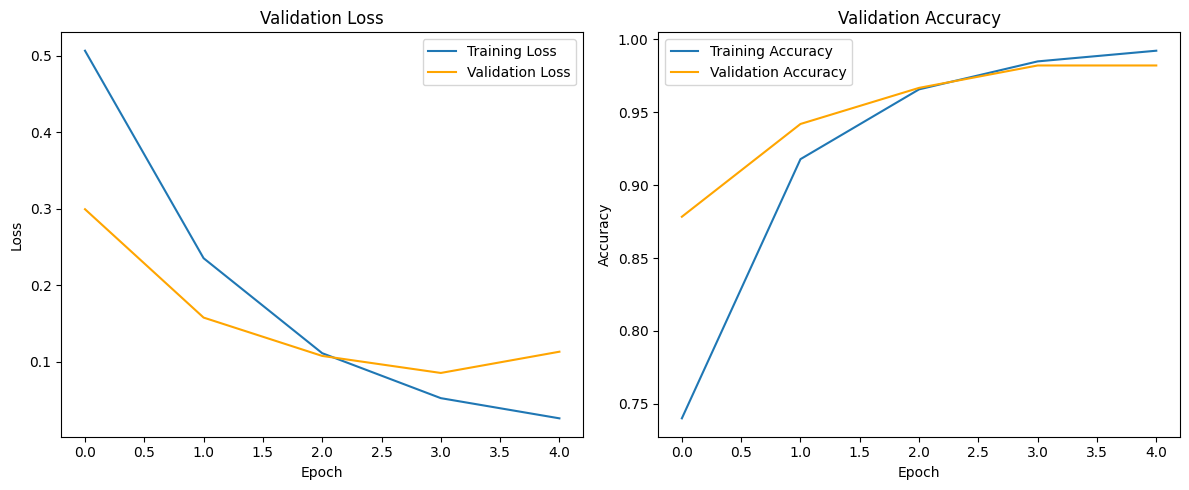

In [37]:
# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
 
# Plot validation loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss',color='orange')
ax1.set_title('Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
 
# Plot validation accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
 
# Adjust layout
plt.tight_layout()
 
# Show the plots
plt.show()

In [38]:
#evaluating loss and accuray of the model
loss, accuracy = model.evaluate(test_padded,testing_labels_final)
print(f'Accurcy on test dataset :{round(accuracy*100,2)}%')

173/173 [==============================] - 1s 4ms/step - loss: 0.0850 - accuracy: 0.9855
Accurcy on test dataset :98.55%


### Confusion Matrix

In [39]:
#predicting the model 
 
pred_prob = model.predict(test_padded)
pred_label = [1 if prob >= 0.5 else 0 for prob in pred_prob]
pred_label[:5]

173/173 [==============================] - 1s 4ms/step


[1, 1, 1, 1, 0]

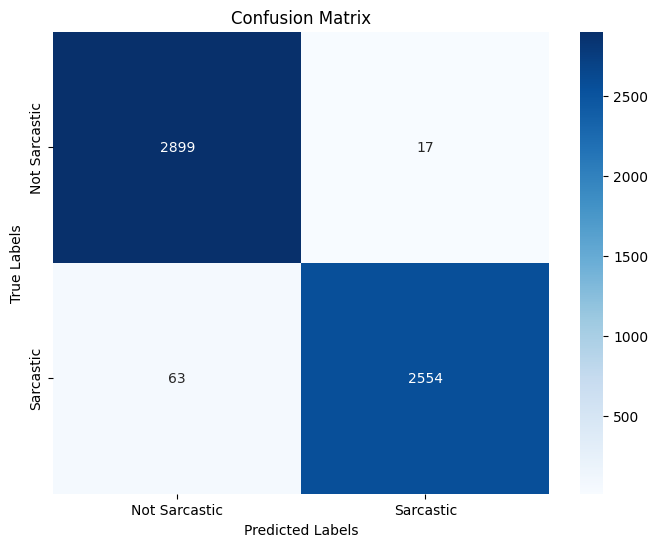

In [40]:
# Compute confusion matrix using the predicted classes and true labels
conf_matrix = confusion_matrix(testing_labels_final, pred_label)
 
# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Sarcastic', 'Sarcastic'],
            yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Classification Report (Sarcastic or not?)

In [41]:
# Print Classification Report
print("\nClassification Report:")
print(classification_report(testing_labels_final, pred_label,
                            target_names=['Not Sarcastic', 'Sarcastic']))


Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.98      0.99      0.99      2916
    Sarcastic       0.99      0.98      0.98      2617

     accuracy                           0.99      5533
    macro avg       0.99      0.99      0.99      5533
 weighted avg       0.99      0.99      0.99      5533



### Live Testing of the Model by user

In [51]:
while True:
    # Prompt the user to input a headline or exit
    user_input = input(
        "Enter a headline for prediction (or type 'exit' to quit): ")
 
    # Check if the user wants to exit
    if user_input.lower() == 'exit':
        break
 
    # Clean and preprocess user input
    cleaned_input = clean_text(user_input)
    tokenized_input = tokenizer.texts_to_sequences(
        [cleaned_input])  # Tokenize the cleaned text
    padded_input = pad_sequences(
        tokenized_input, maxlen=max_length, padding=padding_type)  # Pad the tokenized text
 
    # Predict sarcasm
    prediction = model.predict(padded_input)
 
    # Print the prediction result
    if prediction >= 0.5:
        print(f"Headline: {user_input}\nPrediction: Sarcastic")
    else:
        print(f"Headline: {user_input}\nPrediction: Not Sarcastic")

Enter a headline for prediction (or type 'exit' to quit): you are a charmer
1/1 [==============================] - 0s 41ms/step
Headline: you are a charmer
Prediction: Sarcastic
Enter a headline for prediction (or type 'exit' to quit): thats what she said
1/1 [==============================] - 0s 50ms/step
Headline: thats what she said
Prediction: Not Sarcastic
Enter a headline for prediction (or type 'exit' to quit): exit
